In [1]:
import boto3, os, sagemaker
from sagemaker import get_execution_role

iam_role = get_execution_role()

my_region = boto3.Session().region_name

sm_session = sagemaker.session.Session(boto3.Session())

print("Success")

Success


In [15]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sagemaker.amazon.amazon_estimator import get_image_uri

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
cols_dict = pickle.load(open('cols_dict.pickle', 'rb'))
adult = pd.read_csv("s3://mgta495-project/adult.data", header=None, delimiter=r",\s+")
adult.columns = [cols for cols in cols_dict.keys()]
adult.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Data Transformations

#### Remove missing values

In [4]:
for x in range(len(list(adult.columns))):
    print("{} number of missing values in column {}".format(sum((adult.iloc[:,x]).astype('str').str.contains('\?')), 
          list(adult.columns)[x]))

0 number of missing values in column age
1836 number of missing values in column workclass
0 number of missing values in column fnlwgt
0 number of missing values in column education
0 number of missing values in column education-num
0 number of missing values in column marital-status
1843 number of missing values in column occupation
0 number of missing values in column relationship
0 number of missing values in column race
0 number of missing values in column sex
0 number of missing values in column capital-gain
0 number of missing values in column capital-loss
0 number of missing values in column hours-per-week
583 number of missing values in column native-country
0 number of missing values in column income


In [5]:
adult['workclass'] = np.where(adult['workclass']=='?', None, adult['workclass'])
adult['occupation'] = np.where(adult['occupation']=='?', None, adult['occupation'])
adult['native-country'] = np.where(adult['native-country']=='?', None, adult['native-country'])

adult = adult[(adult['workclass'].notnull()) & (adult['occupation'].notnull()) & (adult['native-country'].notnull())]

In [6]:
for x in range(len(list(adult.columns))):
    print("{} number of missing values in column {}".format(sum(adult.iloc[:,x].isnull()), 
          list(adult.columns)[x]))

0 number of missing values in column age
0 number of missing values in column workclass
0 number of missing values in column fnlwgt
0 number of missing values in column education
0 number of missing values in column education-num
0 number of missing values in column marital-status
0 number of missing values in column occupation
0 number of missing values in column relationship
0 number of missing values in column race
0 number of missing values in column sex
0 number of missing values in column capital-gain
0 number of missing values in column capital-loss
0 number of missing values in column hours-per-week
0 number of missing values in column native-country
0 number of missing values in column income


#### Transform skewed variables

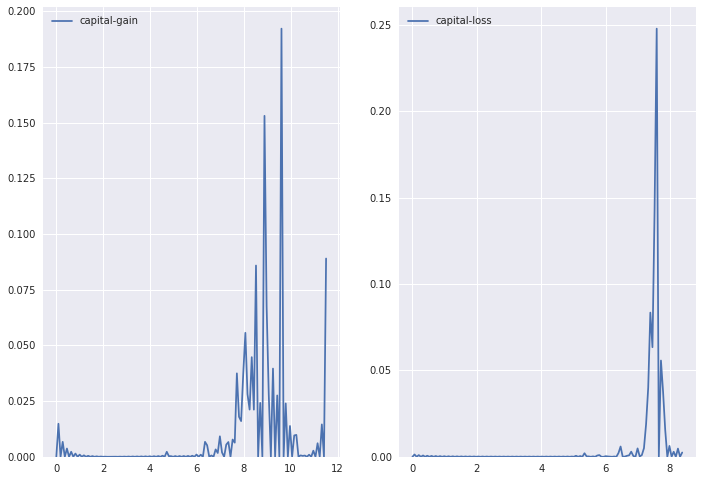

In [16]:
fig, axs = plt.subplots(ncols=2)
sns.kdeplot(adult['capital-gain'], ax=axs[0])
sns.kdeplot(adult['capital-loss'], ax=axs[1])
plt.show()

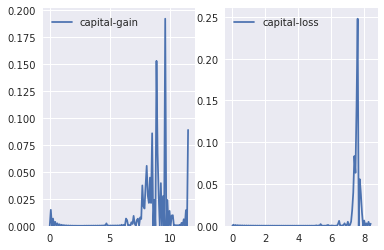

In [8]:
adult['capital-gain'] = np.log(adult['capital-gain']+1)
adult['capital-loss'] = np.log(adult['capital-loss']+1)

fig, axs = plt.subplots(ncols=2)
sns.kdeplot(adult['capital-gain'], ax=axs[0])
sns.kdeplot(adult['capital-loss'], ax=axs[1])
plt.show()

#### Create dummy/one-hot encoded variables and scale variables 

In [9]:
features = list(adult.drop(['fnlwgt'], axis=1).columns)
expl = adult.loc[:, features]
expl = expl[['income', 'age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 
             'race','sex','capital-gain','capital-loss','hours-per-week','native-country']]
expl['income'] = np.where(expl['income']=='>50K', 1, 0)

label = adult.loc[:, 'income']
label = np.where(label=='>50K', 1, 0)

expl = pd.get_dummies(expl)

In [10]:
expl

,income,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0,39,13,7.684784,0.000000,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,50,13,0.000000,0.000000,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,38,9,0.000000,0.000000,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,53,7,0.000000,0.000000,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,28,13,0.000000,0.000000,40,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,0,37,14,0.000000,0.000000,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
6,0,49,5,0.000000,0.000000,16,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,1,52,9,0.000000,0.000000,45,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,1,31,14,9.552866,0.000000,50,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
9,1,42,13,8.552367,0.000000,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
num_vars = [var for var in expl.columns if expl[var].dtypes=='int64' or expl[var].dtypes=='float64']
scaler = MinMaxScaler()

expl[num_vars] = scaler.fit_transform(expl[num_vars])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### Split data in train/test

In [84]:
X_train, X_test, y_train, y_test = train_test_split(expl, label, test_size = 0.2, random_state = 1234)  

print("Training set has {} samples.".format(X_train.shape[0])) 
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 24129 samples.
Testing set has 6033 samples.


#### Final data visualizations

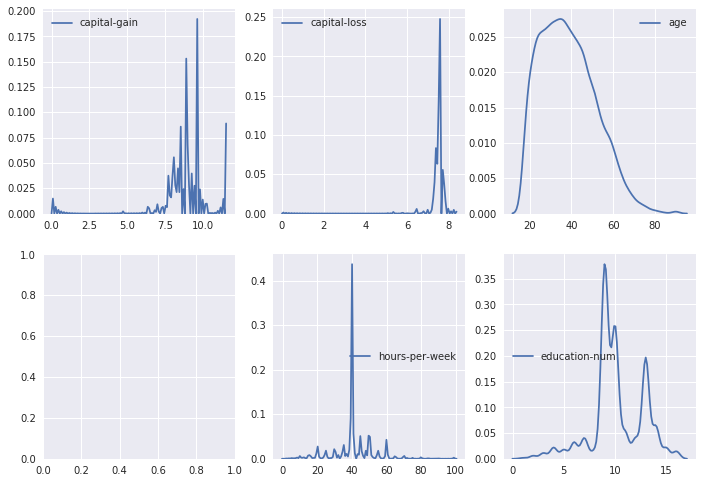

In [17]:
fig, axs = plt.subplots(ncols=3, nrows=2)

sns.kdeplot(adult['capital-gain'], ax=axs[0, 0])
sns.kdeplot(adult['capital-loss'], ax=axs[0, 1])
sns.kdeplot(adult['age'], ax=axs[0, 2])
sns.kdeplot(adult['hours-per-week'], ax=axs[1, 1])
sns.kdeplot(adult['education-num'], ax=axs[1, 2])

### Save data to S3

In [18]:
bucket = "mgta495-project"       
prefix = "sagemaker/logreg"   

datasets = [('train', X_train.values), ('test', X_test.values)]  # Note: also using val as test
data_locations = []
for key, x in datasets:
    file = "{}/{}_data/data.csv".format(prefix,key)
    location = "s3://{}/{}".format(bucket, file); data_locations += [location]
    print('{} data will be uploaded to: {}'.format(key, location))
    np.savetxt("{}.csv".format(key), x, delimiter=',')
    boto3.Session().resource('s3').Bucket(bucket).Object(file).upload_file("{}.csv".format(key))

train data will be uploaded to: s3://mgta495-project/sagemaker/logreg/train_data/data.csv
test data will be uploaded to: s3://mgta495-project/sagemaker/logreg/test_data/data.csv


In [19]:
output_location = "s3://{}/{}/output".format(bucket,prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://mgta495-project/sagemaker/logreg/output


## Creating a model

In [20]:
train_channel = sagemaker.inputs.s3_input(data_locations[0], content_type='text/csv')
test_channel = sagemaker.inputs.s3_input(data_locations[1], content_type='text/csv')

data_channels = {'train': train_channel, 'test': test_channel}

In [21]:
training_image = get_image_uri(boto3.Session().region_name, 'linear-learner')
smclient = boto3.Session().client('sagemaker')

linear = sagemaker.estimator.Estimator(training_image,
                                       role=iam_role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.m5.xlarge',
                                       train_volume_size = 5,
                                       output_path=output_location,
                                       sagemaker_session=sm_session)

In [22]:
n_features = len(list(X_train.columns))

linear.set_hyperparameters(feature_dim=n_features-1,
                           predictor_type='binary_classifier')

linear.fit(data_channels)

2020-03-17 17:45:22 Starting - Starting the training job...
2020-03-17 17:45:23 Starting - Launching requested ML instances......
2020-03-17 17:46:23 Starting - Preparing the instances for training...
2020-03-17 17:47:09 Downloading - Downloading input data...
2020-03-17 17:47:43 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/17/2020 17:47:44 INFO 139773606508352] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_meth

In [23]:
linear.model_data

's3://mgta495-project/sagemaker/logreg/output/linear-learner-2020-03-17-17-45-22-216/output/model.tar.gz'

### Deploying the model and Evaluating the model's performance

In [45]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 content_type = 'text/csv',
                                 instance_type='ml.t2.xlarge')

Using already existing model: linear-learner-2020-03-17-17-45-22-216


-----------!

In [ ]:
if 'pred_proba' in list(X_test.columns):
    if 'pred_proba_tuned' in list(X_test.columns):
        preds = linear_predictor.predict(X_test.iloc[:, 1:len(X_test.columns)-2].values)
    else:
        preds = linear_predictor.predict(X_test.iloc[:, 1:len(X_test.columns)-1].values)
else:
    preds = linear_predictor.predict(X_test.iloc[:, 1:].values)

In [121]:
X_test['pred_proba'] = [p['score'] for p in preds['predictions']]
pred_proba = [p['score'] for p in preds['predictions']]
pred_labels = [p['predicted_label'] for p in preds['predictions']]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Import metrics 

In [315]:
from sklearn.metrics import (confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve, classification_report)

In [132]:
auc = roc_auc_score(X_test['income'], pred_labels)
prec = precision_score(X_test['income'], pred_labels)
rec = recall_score(X_test['income'], pred_labels)
f1 = 2*((prec*rec)/(prec+rec))

metrics = [auc, prec, rec, f1]
labels = ['AUC', 'Precision', 'Recall', 'F1']

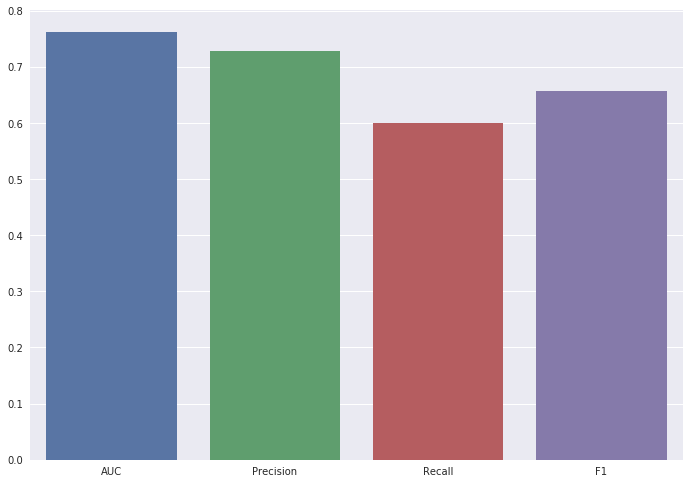

In [135]:
sns.barplot(labels, metrics)
plt.show()

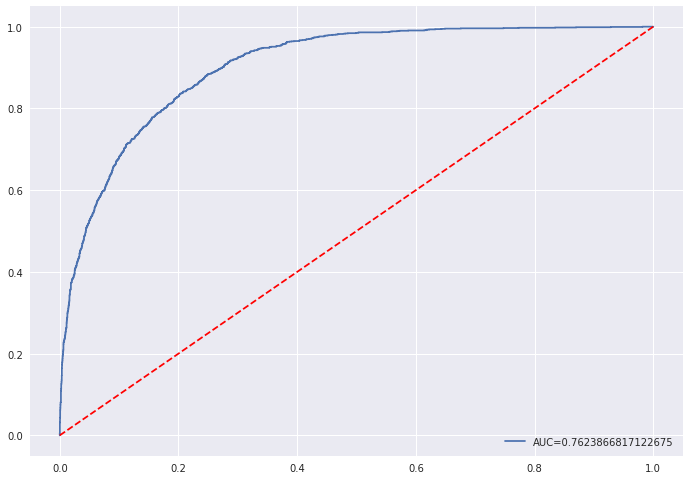

In [356]:
fpr, tpr, _ = roc_curve(X_test['income'], pred_proba)
plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc=4)
plt.show()

In [204]:
linear_predictor.delete_endpoint()

## Hyper Parameter Tuning

In [206]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, CategoricalParameter

# Define exploration boundaries
hyperparameter_ranges = {
    'l1': ContinuousParameter(1e-5, 1),
    'learning_rate': ContinuousParameter(1e-5, 1),
    'positive_example_weight_mult': ContinuousParameter(1e-5, 1e5),
    'use_bias': CategoricalParameter([True, False])
}

# create Optimizer
Optimizer = sagemaker.tuner.HyperparameterTuner(
    estimator=linear,
    hyperparameter_ranges=hyperparameter_ranges,
    base_tuning_job_name='Linear-tuner3',
    objective_type='Maximize',
    objective_metric_name='test:binary_f_beta',
    max_jobs=10,
    max_parallel_jobs=2)

In [207]:
Optimizer.fit(data_channels)

In [208]:
from sagemaker.model import Model

model_location_s3 = "s3://mgta495-project/sagemaker/logreg/output/Linear-tuner3-200317-2142-005-1f7685c3/output/model.tar.gz"

tuned_model = Model(model_location_s3, 
                    image=training_image,
                    role=iam_role, 
                    sagemaker_session=sm_session
                   )
tuned_model.deploy(initial_instance_count=1,
                   instance_type='ml.m4.xlarge',
                  )

------------!

In [231]:
from sagemaker.predictor import RealTimePredictor
tuned_predictor = RealTimePredictor(tuned_model.endpoint_name,
                                    sm_session,
                                    content_type='text/csv')

In [232]:
from sagemaker.predictor import csv_serializer, json_deserializer

tuned_predictor.content_type = 'text/csv'
tuned_predictor.serializer = csv_serializer
tuned_predictor.deserializer = json_deserializer

In [275]:
preds = tuned_predictor.predict(X_test.iloc[:, 1:len(X_test.columns)-1].values)

In [277]:
X_test['pred_proba_tuned'] = [p['score'] for p in preds['predictions']]
pred_proba_tuned = [p['score'] for p in preds['predictions']]
pred_labels_tuned = [p['predicted_label'] for p in preds['predictions']]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [324]:
X_test['customer_cuts'] = pd.cut(X_test['pred_proba_tuned'] ,5, labels=["Section 5", "Section 4", "Section 3","Section 2","Section 1"])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [295]:
auc_tuned = roc_auc_score(X_test['income'], pred_labels_tuned)
prec_tuned = precision_score(X_test['income'], pred_labels_tuned)
rec_tuned = recall_score(X_test['income'], pred_labels_tuned)
f1_tuned = 2*((prec_tuned*rec_tuned)/(prec_tuned+rec_tuned))

metrics_tuned = [auc_tuned, prec_tuned, rec_tuned, f1_tuned]
labels_tuned = ['AUC', 'Precision', 'Recall', 'F1']

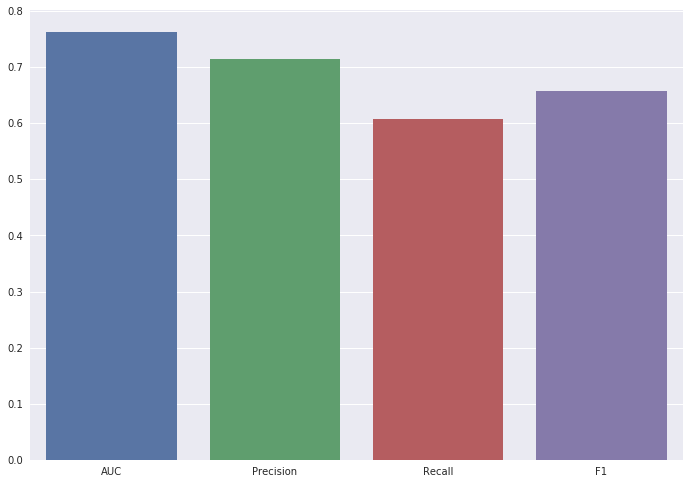

In [304]:
sns.barplot(labels_tuned, metrics_tuned)
plt.show()

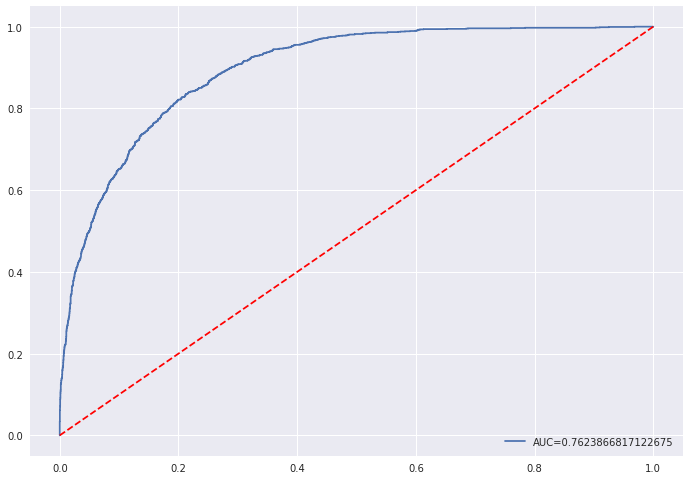

In [320]:
fpr, tpr, _ = roc_curve(X_test['income'], pred_proba_tuned)
plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc=4)
plt.show()

In [316]:
target_names = ['Lower Salary class', 'Higher Salary class']
print(classification_report(X_test['income'], pred_labels_tuned, target_names=target_names))

                     precision    recall  f1-score   support

 Lower Salary class       0.88      0.92      0.90      4525
Higher Salary class       0.71      0.61      0.66      1508

          micro avg       0.84      0.84      0.84      6033
          macro avg       0.79      0.76      0.78      6033
       weighted avg       0.84      0.84      0.84      6033



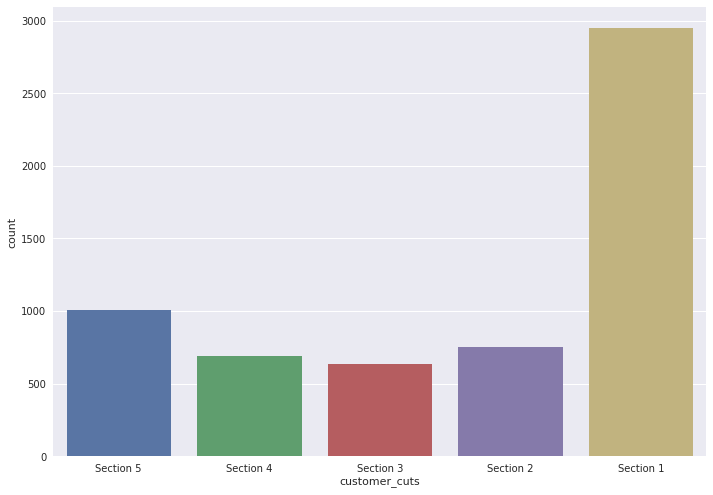

In [326]:
sns.countplot(X_test['customer_cuts'])

In [313]:
tuned_predictor.delete_endpoint()

In [355]:
X_test[X_test['customer_cuts']=='Section 1'].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
income,2947.0,0.476417,0.499528,0.000000,0.000000,0.000000,1.000000,1.000000
age,2947.0,0.358317,0.157735,0.013699,0.232877,0.342466,0.465753,1.000000
education-num,2947.0,0.670739,0.159736,0.066667,0.533333,0.600000,0.800000,1.000000
capital-gain,2947.0,0.121458,0.283307,0.000000,0.000000,0.000000,0.000000,1.000000
capital-loss,2947.0,0.061095,0.226567,0.000000,0.000000,0.000000,0.000000,0.955665
hours-per-week,2947.0,0.439683,0.116549,0.000000,0.397959,0.397959,0.500000,1.000000
workclass_Federal-gov,2947.0,0.044113,0.205380,0.000000,0.000000,0.000000,0.000000,1.000000
workclass_Local-gov,2947.0,0.077367,0.267218,0.000000,0.000000,0.000000,0.000000,1.000000
workclass_Private,2947.0,0.654564,0.475591,0.000000,0.000000,1.000000,1.000000,1.000000
workclass_Self-emp-inc,2947.0,0.062097,0.241373,0.000000,0.000000,0.000000,0.000000,1.000000
